In [166]:
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from pykrige.kriging_tools import write_asc_grid
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [117]:
# 读取数据
data = pd.read_csv('../data/test_data.csv')

In [118]:
# 删除缺失值
# 删除有缺失值的行
data.dropna(inplace=True)
missing_values = data.isnull().sum()
missing_values

Unnamed: 0    0
X             0
Y             0
pre           0
tmp           0
asp           0
slope         0
dem           0
ndvi          0
twi5          0
tpi3          0
tpi11         0
tpi101        0
tpi201        0
dl            0
ph            0
dtype: int64

In [192]:
data.drop(['Unnamed: 0'], axis=1, inplace=True)
data.columns

Index(['X', 'Y', 'pre', 'tmp', 'asp', 'slope', 'dem', 'ndvi', 'twi5', 'tpi3',
       'tpi11', 'tpi101', 'tpi201', 'ph'],
      dtype='object')

In [193]:
data.drop(columns=['dl'],inplace=True)

KeyError: "['dl'] not found in axis"

In [194]:
# 划分测试数据
train_data = data.sample(frac=0.7,random_state=0)   # 80%的数据用于训练
test_data = data.drop(train_data.index)                 # 20%的数据用于测试
train_data.sample()

,X,Y,pre,tmp,asp,slope,dem,ndvi,twi5,tpi3,tpi11,tpi101,tpi201,ph
972,107.008482,28.233823,837.5,137.25,71.544083,0.906293,1228.699951,94,11.069044,-0.032837,-0.418335,-11.80188,-20.258179,5.54


In [195]:
label = 'ph'
train_data[label].describe()

count    5226.000000
mean        5.899742
std         0.938692
min         3.990000
25%         5.190000
50%         5.690000
75%         6.430000
max         8.460000
Name: ph, dtype: float64

In [196]:
predictor = TabularPredictor(label=label).fit(train_data,time_limit=600)

No path specified. Models will be saved in: "AutogluonModels/ag-20230730_115030/"
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230730_115030/"
AutoGluon Version:  0.8.2
Python Version:     3.8.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Apr 2 22:23:49 UTC 2021
Disk Space Avail:   226.64 GB / 269.49 GB (84.1%)
Train Data Rows:    5226
Train Data Columns: 13
Label Column: ph
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (8.46, 3.99, 5.89974, 0.93869)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerato

In [197]:
# 测试数据集
y_test_pred = predictor.predict(test_data.drop(columns=[label]))

In [198]:
y_test_pred

0       5.363788
7       6.073187
19      6.570474
21      5.717265
24      6.360364
          ...   
7477    5.104553
7478    5.771109
7481    5.677615
7485    5.743721
7489    6.979800
Name: ph, Length: 2239, dtype: float32

In [199]:
# 训练数据集
y_train_pred = predictor.predict(train_data.drop(columns=[label]))
y_train = train_data[label]

In [200]:

y_test = test_data[label]

In [201]:
# 计算残差
residuals_test =y_train - y_train_pred
residuals_test

2429   -0.219116
3445    0.353061
39     -0.052850
3256   -0.074735
5597    0.798366
          ...   
1651   -0.716878
7372   -1.586143
4446    0.393240
3382    0.500850
6303    0.345869
Name: ph, Length: 5226, dtype: float64

In [202]:
# 高斯克里金
OK = OrdinaryKriging(train_data['X'], train_data['Y'], residuals_test, variogram_model='gaussian')  # 高斯模型
# 在测试数据上进行预测
kriging_predictions_test, _ = OK.execute('points', test_data['X'], test_data['Y'])
predictions_test = y_test + kriging_predictions_test

# 计算R2
r2 = r2_score(y_test, predictions_test)
r2

0.998827758668657

In [203]:
new_r2 = r2_score(y_test, y_test_pred)
new_r2

0.3791386053355804

In [153]:
# 重新计算预测值

def calc_predict_value(actual_value, predict_value):
    diff = np.abs(actual_value - predict_value)/actual_value
    modified_diff = np.where(diff <= 0.15, actual_value, predict_value)
    return modified_diff


In [204]:
t_pred = calc_predict_value(test_data[label],y_test_pred)
t_pred

array([4.78      , 5.46      , 6.67      , ..., 5.67761469, 6.55      ,
       7.03      ])

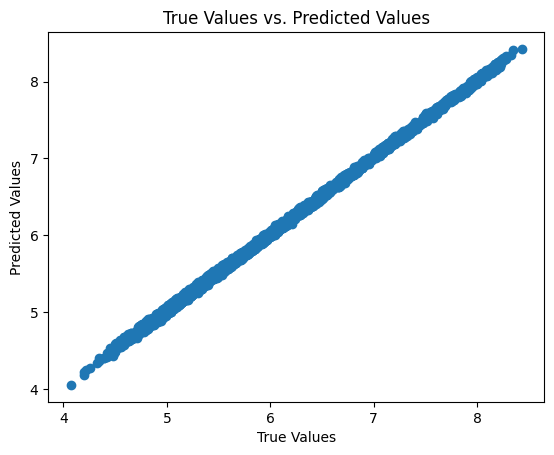

In [205]:
plt.scatter(y_test, predictions_test)

# 添加标签和标题
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True Values vs. Predicted Values')

# 显示图表
plt.show()

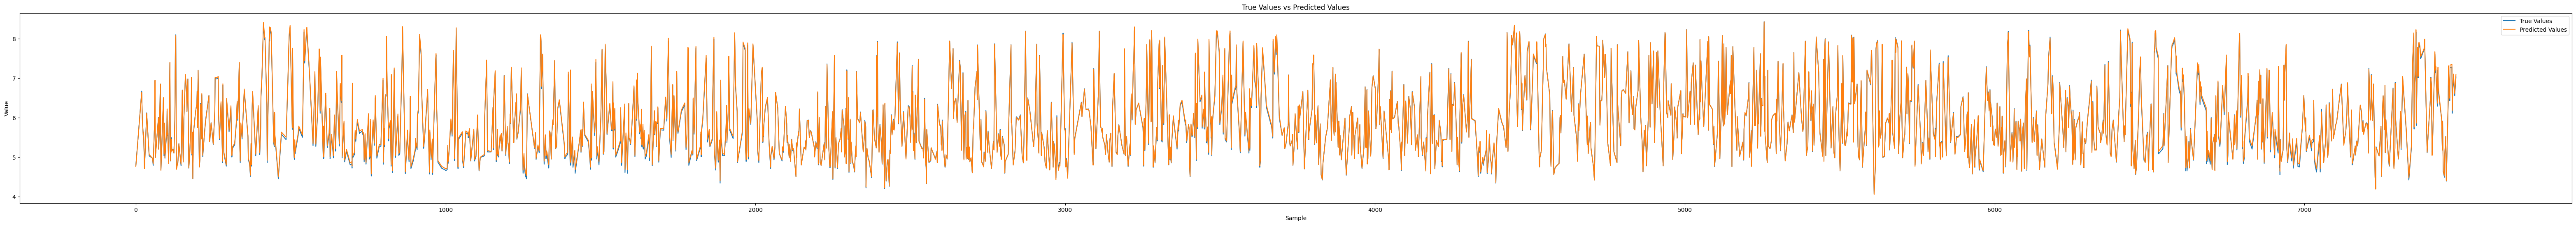

In [206]:
# 创建折线图
plt.figure(figsize=(80,6))
plt.plot(test_data[label], label='True Values')
plt.plot(predictions_test, label='Predicted Values')

# 图表标题和标签
plt.title('True Values vs Predicted Values')
plt.xlabel('Sample')
plt.ylabel('Value')

# 添加图例
plt.legend()

# 显示图表
plt.show()

In [207]:
predictor.evaluate(test_data, silent=True)

{'root_mean_squared_error': -0.7455795085171434,
 'mean_squared_error': -0.5558888035206652,
 'mean_absolute_error': -0.5843391518467183,
 'r2': 0.3791386053355804,
 'pearsonr': 0.6194983416519211,
 'median_absolute_error': -0.48797634124755884}

In [210]:

def calculate_modified_r2(y_true, y_pred):
    diff = np.abs(y_true - y_pred)/y_true
    modified_diff = np.where(diff <= 0.16, 0, np.abs(y_true - y_pred))
    modified_ssr = np.sum(modified_diff**2)
    
    mean = np.mean(y_true)
    total_diff = np.sum((y_true - mean)**2)
    
    r2 = 1 - (modified_ssr / total_diff)
    return r2

print(calculate_modified_r2(test_data[label], y_test_pred))

0.609439123514638


In [211]:
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM,-0.740984,-0.715480,0.004364,0.001683,0.278744,0.004364,0.001683,0.278744,1,True,4
1,CatBoost,-0.742429,-0.719959,0.007320,0.003921,0.853909,0.007320,0.003921,0.853909,1,True,6
2,XGBoost,-0.744168,-0.721155,0.008503,0.002826,0.369916,0.008503,0.002826,0.369916,1,True,9
3,WeightedEnsemble_L2,-0.745580,-0.704676,0.157524,0.105308,6.668760,0.002670,0.000307,0.142850,2,True,12
4,ExtraTreesMSE,-0.746194,-0.715443,0.111731,0.077044,0.453620,0.111731,0.077044,0.453620,1,True,7
5,LightGBMXT,-0.751865,-0.729285,0.009533,0.002803,2.066669,0.009533,0.002803,2.066669,1,True,3
6,RandomForestMSE,-0.752279,-0.726674,0.142602,0.078026,1.356102,0.142602,0.078026,1.356102,1,True,5
7,LightGBMLarge,-0.754259,-0.723016,0.005863,0.001856,0.744382,0.005863,0.001856,0.744382,1,True,11
8,NeuralNetFastAI,-0.791416,-0.752817,0.031447,0.010445,2.681727,0.031447,0.010445,2.681727,1,True,8
9,NeuralNetTorch,-0.814286,-0.745130,0.007905,0.004695,4.672598,0.007905,0.004695,4.672598,1,True,10
